# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201015/MC/2016/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/MC_2016/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/MC_3years/0p996_2016/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [
    
#         'H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
        'QCD_HT_all, background',
        'WLNu_HT_all, background',
        'ZNunu_HT_all, background',
        'TT_Lep, background',

#         'Data 2016',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v20/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['QCD_HT_all, background'] = 'V1p17/v28/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu_HT_all, background'] = 'V1p17/v28/MC_Summer16/normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'V1p17/v28/MC_Summer16/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'V1p17/v28/MC_Summer16/normalized/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['Data 2016'] = 'V1p17/v20/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v28/MC_Summer16/normalized/QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root
Open ready
QCD_HT_all, background
Tree ready
<TTree b'SusyLLPTree' at 0x7ff3031a8e48> OrderedDict([('QCD_HT_all, background', <TTree b'SusyLLPTree' at 0x7ff3031a8e48>)])
[[0.4162015 0.75947815 0.30964914] [0.68769044] [0.23462042 0.3599532] ... [0.45821705] [0.11395924 0.6486315 0.24078467] [0.3709789]]
[7.935079e-05 7.935079e-05 7.935079e-05 7.935079e-05 7.935079e-05
 7.935079e-05 7.935079e-05 7.935079e-05 7.935079e-05 7.935079e-05]
[4.2196252e-06 1.0127245e-05 7.9350793e-05 1.5036011e-04 5.0976203e-04
 6.3758474e-03]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v28/MC_Summer16/normalized/WJetsToLNu_HT-70ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root
Open ready
WLNu_HT_all, background
Tree ready
<TTree b'SusyLLPTree' at 0x7ff3031d7240> OrderedDict([('QCD_H

# Test/Debug Plot

In [4]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=0

mt_cut=100

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_dnn = {}
trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    mt = v['MT'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
#     flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    dnn = v['jetDNNScoreV3'].array()
#     dnn = v['jetDNNScore'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
    if 'background' in k:
        PUweight = v['pileupWeight'].array()
            
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
#     basic_met_str = np.logical_and(basic_met_str, nlep==0)
#     basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
    if 'background' in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
        


    trg_jet_dnn[k] = dnn[basic_jet_str][met_trg_str]
    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
    if 'background' in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
        
    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()
    
    trg_jet_dnn[k] = trg_jet_dnn[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_jet_csv[k]))
    print(len(trg_jet_nb[k]))

    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
(403196,)


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


297218
297218
297218
297218
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
(6402546,)
6320616
6320616
6320616
6320616
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
(8216171,)
8194535
8194535
8194535
8194535
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
(17053822,)
17022323
17022323
17022323
17022323


In [5]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1pho_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/rebin_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Data/1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
# print(plotDir)
# os.system("mkdir -p "+ plotDir)

# Tags

In [6]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06

# dnn_cut=0.90
# dnn_cut=0.99
dnn_cut=0.996

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
#     tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    tagged_jet = np.logical_and(1, trg_jet_dnn[k]>dnn_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [431.03207] [164.15138]]
[[] [] [] ... [] [] []]
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [431.03207] [164.15138]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0 1]
[0 1]
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
[[97.90426] [160.85762] [] ... [171.48276] [150.74423 45.879417] []]
[[] [] [] ... [] [] []]
[[97.90426] [160.85762] [] ... [171.48276] [150.74423 45.879417] []]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1 2 3]
[0 1 2]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
[[] [] [] ... [] [55.97662] []]
[[] [] [] ... [] [] []]
[[] [] [] ... [] [55.97662] []]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 1 2]
[0 1 2]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
[[] [325.6471 97.66015 70.295044 43.7588

# Tag Eff

In [7]:
from itertools import chain 

wall = {}
wnum = {}

pt_denall = {}
eta_denall = {}
pt_numall = {}
eta_numall = {}

pt_den_all = {}
eta_den_all = {}
pt_num_all = {}
eta_num_all = {}

pt_pEff = {}
eta_pEff = {}


for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    

    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
    print(len(wnum[k]))
    
    #histogram
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    #rebin 
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100])
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,1000])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
    eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
    eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
951855
951855
951855
146
146
146
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
17243779
17243779
17243779
2946
2946
2946
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
15632502
15632502
15632502
2362
2362
2362
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
51002799
51002799
51002799
7787
7787
7787


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEffi

In [8]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'1pho_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Predictions/1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/rebin_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_0btag_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_wjets_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_ttjets_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_1b_ttjets_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/mc_0b_wjets_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Data/1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
# print(plotDir)
# os.system("mkdir -p "+ plotDir)

In [9]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
#         ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.02],
#         ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.01],
    
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>


Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/MC_3years/0p996_20

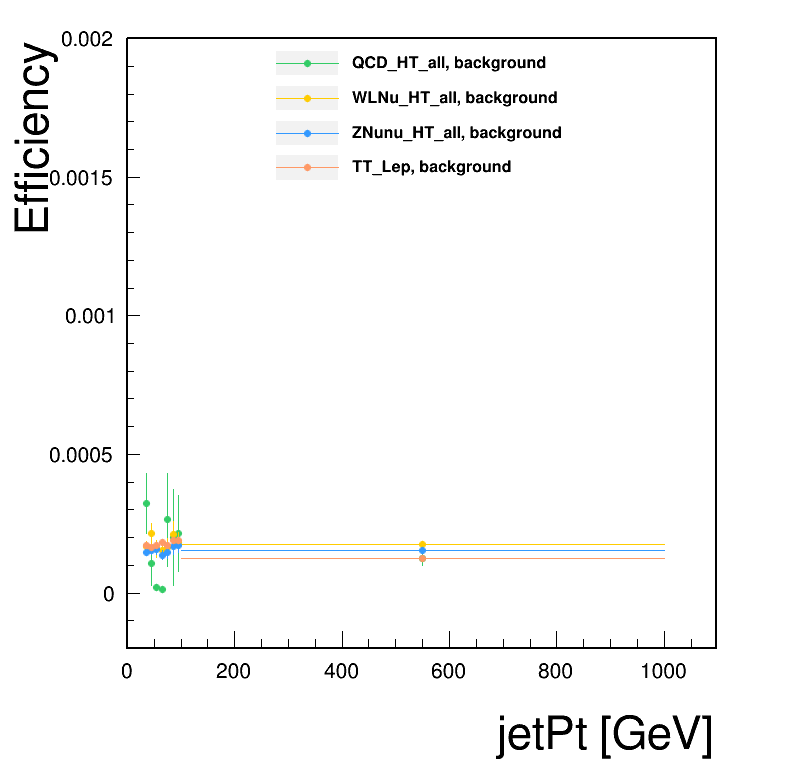

In [10]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.002
QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/MC_3years/0p996_2016/tag_eff_jet_pt_rebin_logX.png has been created


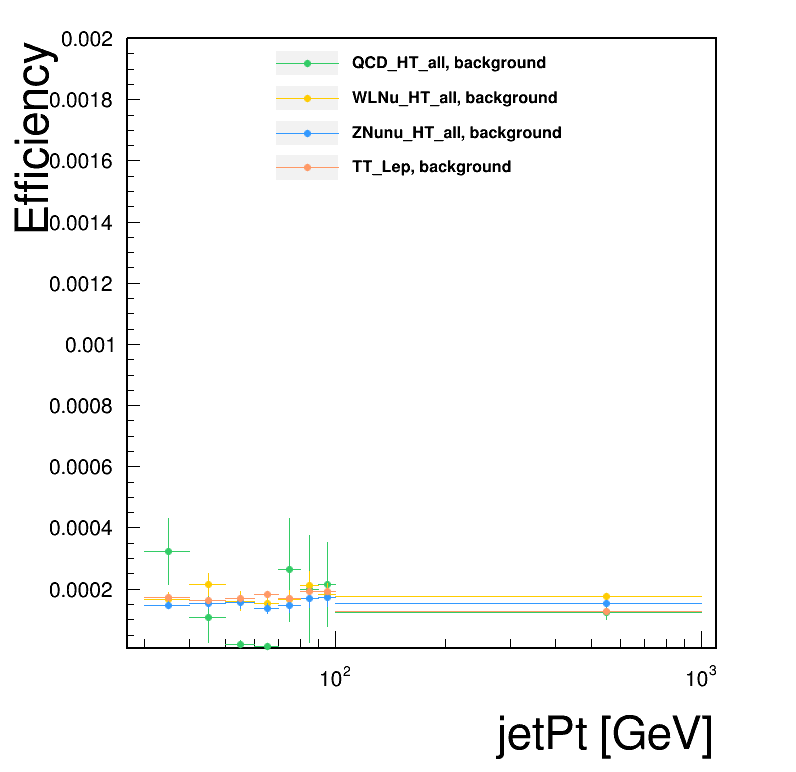

In [11]:

   

color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin_logX.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    c.SetLogx()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Prediction Region

In [12]:
trg_path=467
# trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_dnn = {}
trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
#     flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    dnn = v['jetDNNScoreV3'].array()
#     dnn = v['jetDNNScore'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_dnn[k] = dnn[basic_jet_str][met_trg_str]
    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()
    
    trg_jet_dnn[k] = trg_jet_dnn[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
(403196,)
282733
282733
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
(6402546,)
2520676
2520676
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
(8216171,)
7873815
7873815
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
(17053822,)
6317984
6317984


In [13]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Data/0lep_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_from_0btag_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_from_wjets_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_from_ttjets_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_from_1b_ttjets_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_from_0b_wjets_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'MC_Closure/0lep_mc_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Predictions/1pho_0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Predictions/0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'0lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6_mdphi_0p5_invert/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200520/'+'Predictions/1lep_sig_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
 
# print(plotDir)
# os.system("mkdir -p "+ plotDir)

In [14]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

# dnn_cut=0.90
# dnn_cut=0.99
dnn_cut=0.996

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
#     tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    tagged_jet = np.logical_and(1, trg_jet_dnn[k]>dnn_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [431.03207] [164.15138]]
[[] [] [] ... [] [] []]
[[593.0364 249.53702 36.278683] [565.5163] [569.83136 280.0468] ... [541.42993 462.4637 333.806] [431.03207] [164.15138]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0 1]
[0 1]
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
[[] [] [111.41341 68.699135] ... [177.22496] [187.65535] []]
[[] [] [] ... [] [] []]
[[] [] [111.41341 68.699135] ... [177.22496] [187.65535] []]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0 1 2 3]
[0 1 2]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
[[] [] [] ... [] [55.97662] []]
[[] [] [] ... [] [] []]
[[] [] [] ... [] [55.97662] []]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 1 2]
[0 1 2]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
[[] [325.6471 97.66015 70.295044 43.758858] [156.82986 82.2

In [15]:
# fout = plotDir+'Numbers_predictions.txt'
# ouf = open(fout,"w+")
# long_str = '############################## \n'
# long_str += 'Before Predictions \n'
# long_str += '############################## \n'
# for k,v in tree.items():
#     if 'Data' in k:
#         lumi=1
#         sf=1
#     elif 'QCD' in k:
#         lumi=35900
#         sf=1.2
#     else:
#         lumi=35900
#         sf=1
#     long_str+=k
#     long_str+='\n'
#     for binN in range(2):
#         long_str+='Tag Bin '
#         long_str+=str(binN)
#         long_str+=': '
#         long_str+=str(sum(trg_jet_w[k][nTags[k]==binN])*lumi*sf)
#         long_str+='\n'
#         long_str+='Tag Bin '
#         long_str+=str(binN)
#         long_str+=' Error: '
#         long_str+=str(math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==binN]))*lumi*sf)
#         long_str+='\n'
#     if 'Data' not in k:
#         binN=2
#         long_str+='Tag Bin '
#         long_str+=str(binN)
#         long_str+=': '
#         long_str+=str(sum(trg_jet_w[k][nTags[k]==binN])*lumi*sf)
#         long_str+='\n'
#         long_str+='Tag Bin '
#         long_str+=str(binN)
#         long_str+=' Error: '
#         long_str+=str(math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==binN]))*lumi*sf)
#         long_str+='\n'
# ouf.write(long_str)
# ouf.close()

In [16]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 0 Yield', 'Bin 0 Error', 'Bin 1 Yield', 'Bin 1 Error', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.2
    else:
        lumi=35900
        sf=1
    bin0_str=np.logical_and(nTags[k]==0, 1)
    bin1_str=np.logical_and(nTags[k]==1, 1)
    bin2_str=np.logical_and(nTags[k]==2, 1)
#     bin0_str=np.logical_and(nTags[k]==0, trg_jet_nb[k]<btag_cut)
#     bin1_str=np.logical_and(nTags[k]==1, trg_jet_nb[k]<btag_cut)
#     bin2_str=np.logical_and(nTags[k]==2, trg_jet_nb[k]<btag_cut)
#     bin0_str=np.logical_and(nTags[k]==0, trg_jet_nb[k]>=btag_cut)
#     bin1_str=np.logical_and(nTags[k]==1, trg_jet_nb[k]>=btag_cut)
#     bin2_str=np.logical_and(nTags[k]==2, trg_jet_nb[k]>=btag_cut)
    
    if 'Data' not in k:
        row = [k, round (sum(trg_jet_w[k][bin0_str])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][bin0_str]))*lumi*sf, 2) , round (sum(trg_jet_w[k][bin1_str])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][bin1_str]))*lumi*sf, 2) , round (sum(trg_jet_w[k][bin2_str])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][bin2_str]))*lumi*sf, 2)  ]
    else:
        row = [k, round (sum(trg_jet_w[k][bin0_str])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][bin0_str]))*lumi*sf, 2) , round (sum(trg_jet_w[k][bin1_str])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][bin1_str]))*lumi*sf, 2) , 0.0 , 0.0  ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|          Sample          | Bin 0 Yield | Bin 0 Error | Bin 1 Yield | Bin 1 Error | Bin 2 Yield | Bin 2 Error |
+--------------------------+-------------+-------------+-------------+-------------+-------------+-------------+
|  QCD_HT_all, background  |  477072.13  |    2627.4   |    171.14   |    26.22    |     0.0     |     0.0     |
| WLNu_HT_all, background  |  184180.71  |    265.24   |    69.68    |     4.14    |     0.19    |     0.07    |
| ZNunu_HT_all, background |  640257.22  |    319.96   |    138.75   |     4.03    |     0.22    |     0.07    |
|    TT_Lep, background    |   129923.1  |    51.71    |    66.11    |     1.17    |     0.12    |     0.05    |
+--------------------------+-------------+-------------+-------------+-------------+-------------+-------------+


In [17]:
table_txt = table.get_string()
with open(plotDir+'/BeforePredictionSummaryTableRebin.txt','w') as file:
# with open(plotDir+'/BeforePredictionSummaryTable.txt','w') as file:
    file.write(table_txt)

In [18]:
print(chr(177))

±


# Fake rate method

In [19]:
def GetEffWeight(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    for evt in range(len(pts)):
        binN=peff.GetPassedHistogram().FindBin(pts[evt])
        
        eff=peff.GetEfficiency(binN)
        errUp=peff.GetEfficiencyErrorUp(binN)
        errLow=peff.GetEfficiencyErrorLow(binN)
        
        effUp=eff+errUp
        effLow=eff-errLow
        
        effW=ws[evt]*eff
        effWUp=ws[evt]*effUp
        effWLow=ws[evt]*effLow
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [20]:
# jet_bool = {}

cr_nj_cut = 1
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_ws={}

pred_jet_ws={}
pred_jet_ws_up={}
pred_jet_ws_low={}

for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
#     cr_cut_str=np.logical_and(cr_cut_str, trg_jet_nb[k]<btag_cut)
#     cr_cut_str=np.logical_and(cr_cut_str, trg_jet_nb[k]>=btag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    pred_jet_ws[k], pred_jet_ws_up[k], pred_jet_ws_low[k]  = GetEffWeight(cr_jet_pts[k], cr_jet_ws[k], pt_pEff[k])
    
    print(len(pred_jet_ws[k]))
    
#     print(trg_jet_pt[k][:10])    
#     print(cr_jet_pt[k][:10])
#     print(cr_jet_pts[k][:10])
    
#     print(pt_den_all[k].FindBin(cr_jet_pts[k][0]))
#     print(pt_pEff[k].GetPassedHistogram().FindBin(cr_jet_pts[k][0]))
#     print(pt_pEff[k].GetEfficiency(pt_den_all[k].FindBin(cr_jet_pts[k][0])))
#     print(pt_pEff[k].GetEfficiencyErrorLow(pt_den_all[k].FindBin(cr_jet_pts[k][0])))
#     print(pt_pEff[k].GetEfficiencyErrorUp(pt_den_all[k].FindBin(cr_jet_pts[k][0])))
#     print(pt_pEff[k].GetPassedHistogram().GetBinCenter(pt_den_all[k].FindBin(cr_jet_pts[k][0])))
 
    
    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
279541
279541
908106
908106
908106
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
2439655
2439655
7228926
7228926
7228926
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
7051168
7051168
15050523
15050523
15050523
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
6101289
6101289
20225160
20225160
20225160


In [21]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 1 Prediction', 'Bin 1 Prediction Error Up', 'Bin 1 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.2
    else:
        lumi=35900
        sf=1
    ws_sq = np.array([x*x for x in pred_jet_ws[k]])
    row = [k, round (sum(pred_jet_ws[k])*lumi*sf, 2) , round ( math.sqrt(np.sum(ws_sq))*lumi*sf  , 2) , round ( math.sqrt(np.sum(ws_sq))*lumi*sf  , 2) ,]
#     row = [k, round (sum(pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pred_jet_ws_up[k])-sum(pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pred_jet_ws_low[k])-sum(pred_jet_ws[k]))*lumi*sf  , 2)]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------------------------+------------------+---------------------------+----------------------------+
|          Sample          | Bin 1 Prediction | Bin 1 Prediction Error Up | Bin 1 Prediction Error Low |
+--------------------------+------------------+---------------------------+----------------------------+
|  QCD_HT_all, background  |      163.69      |            0.56           |            0.56            |
| WLNu_HT_all, background  |      58.49       |            0.05           |            0.05            |
| ZNunu_HT_all, background |      138.99      |            0.05           |            0.05            |
|    TT_Lep, background    |      63.45       |            0.01           |            0.01            |
+--------------------------+------------------+---------------------------+----------------------------+


In [22]:
table_txt = table.get_string()
with open(plotDir+'/PredictionSummaryTableRebin.txt','w') as file:
# with open(plotDir+'/PredictionSummaryTable.txt','w') as file:
    file.write(table_txt)

# Bin2 prediction

In [23]:
def GetEffWeightBin2(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    evt=0
    for evt in range(len(pts)):
        cnt=0
        p2=0
        p2Up=0
        p2Low=0
        for cnt in range(len(pts[evt])):
            binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
            eff1=peff.GetEfficiency(binN)
            errUp1=peff.GetEfficiencyErrorUp(binN)
            errLow1=peff.GetEfficiencyErrorLow(binN)
        
            effUp1=eff1+errUp1
            effLow1=eff1-errLow1
            
            ct=0
            for ct in range(len(pts[evt])):
                
                binN=peff.GetPassedHistogram().FindBin(pts[evt][ct])

                eff2=peff.GetEfficiency(binN)
                errUp2=peff.GetEfficiencyErrorUp(binN)
                errLow2=peff.GetEfficiencyErrorLow(binN)

                effUp2=eff2+errUp2
                effLow2=eff2-errLow2
            
                if ct>cnt:
                    p2=p2+eff1*eff2
                    p2Up=p2Up+effUp1*effUp2
                    p2Low=p2Low+effLow1*effLow2

        effW=ws[evt]*p2
        effWUp=ws[evt]*p2Up
        effWLow=ws[evt]*p2Low
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [24]:
# jet_bool = {}

cr_nj_cut = 2
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_eta={}
cr_jet_phi={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_etas={}
cr_jet_phis={}
cr_jet_ws={}

pt_pred_jet_ws={}
pt_pred_jet_ws_up={}
pt_pred_jet_ws_low={}

 
for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_eta[k] = trg_jet_eta[k][cr_cut_str]
    cr_jet_phi[k] = trg_jet_phi[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    # to bin1
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_etas[k] = cr_jet_eta[k].flatten()
    cr_jet_phis[k] = cr_jet_phi[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    # to bin2
    pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin2(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    
 
    
 
    

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031a8e48>
254900
254900
883465
883465
WLNu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff3031d7240>
2091519
2091519
6880790
6880790
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7ff301541c88>
4528348
4528348
12527703
12527703
TT_Lep, background <TTree b'SusyLLPTree' at 0x7ff13f5f9390>
5486549
5486549
19610420
19610420


In [25]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 2 Prediction', 'Bin 2 Prediction Error Up', 'Bin 2 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    elif 'QCD' in k:
        lumi=35900
        sf=1.2
    else:
        lumi=35900
        sf=1
    ws_sq = np.array([x*x for x in pt_pred_jet_ws[k]])
    row = [k, round (sum(pt_pred_jet_ws[k])*lumi*sf, 2) , round ( math.sqrt(np.sum(ws_sq))*lumi*sf  , 2) , round ( math.sqrt(np.sum(ws_sq))*lumi*sf  , 2) ,]
    
#     row = [k, round (sum(pred_jet_ws[k])*lumi*sf, 2) , round (abs(sum(pred_jet_ws_up[k])-sum(pred_jet_ws[k]))*lumi*sf  , 2) , round (abs(sum(pred_jet_ws_low[k])-sum(pred_jet_ws[k]))*lumi*sf  , 2)]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------------------------+------------------+---------------------------+----------------------------+
|          Sample          | Bin 2 Prediction | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+--------------------------+------------------+---------------------------+----------------------------+
|  QCD_HT_all, background  |       0.03       |            0.0            |            0.0             |
| WLNu_HT_all, background  |       0.01       |            0.0            |            0.0             |
| ZNunu_HT_all, background |       0.01       |            0.0            |            0.0             |
|    TT_Lep, background    |       0.01       |            0.0            |            0.0             |
+--------------------------+------------------+---------------------------+----------------------------+


In [26]:
table_txt = table.get_string()
with open(plotDir+'/PredictionSummaryTable2.txt','w') as file:
    file.write(table_txt)